In [ ]:
# !pip install torchutils

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maximtalakin","key":"a23e1a962434339b3274c729f324d4d0"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
License(s): unknown
 86% 279M/325M [00:00<00:00, 568MB/s]
100% 325M/325M [00:00<00:00, 567MB/s]


In [8]:
!pwd

/content


In [9]:
!ls

kaggle.json  sample_data  skin-cancer-malignant-vs-benign.zip


In [10]:
import zipfile
import os

# Путь к скачанному архиву
zip_path = 'skin-cancer-malignant-vs-benign.zip'

# Проверяем что архив существует
if os.path.exists(zip_path):
    print(f"✅ Архив найден: {zip_path}")
    print(f"📦 Размер архива: {os.path.getsize(zip_path) / 1024 / 1024:.2f} MB")

    # Создаем папку для распакованных данных
    extract_path = '/content/skin_cancer_data'
    os.makedirs(extract_path, exist_ok=True)

    # Распаковываем архив
    print("📤 Распаковываем архив...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("✅ Архив успешно распакован!")
else:
    print(f"❌ Архив не найден: {zip_path}")

✅ Архив найден: skin-cancer-malignant-vs-benign.zip
📦 Размер архива: 324.70 MB
📤 Распаковываем архив...
✅ Архив успешно распакован!


'/content/skin_cancer_data/data/test/malignant/184.jpg'

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Проверяем что скачалось
dataset_path = '/content/skin_cancer_data'  # или путь куда распаковали
print("📂 Содержимое датасета:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:
        print(f"{subindent}{file}")
    if len(files) > 3:
        print(f"{subindent}... и еще {len(files) - 3} файлов")

📂 Содержимое датасета:
skin_cancer_data/
  test/
    malignant/
      184.jpg
      1422.jpg
      519.jpg
      ... и еще 297 файлов
    benign/
      1672.jpg
      419.jpg
      1731.jpg
      ... и еще 357 файлов
  data/
    test/
      malignant/
        184.jpg
        1422.jpg
        519.jpg
        ... и еще 297 файлов
      benign/
        1672.jpg
        419.jpg
        1731.jpg
        ... и еще 357 файлов
    train/
      malignant/
        1469.jpg
        497.jpg
        1255.jpg
        ... и еще 1194 файлов
      benign/
        1562.jpg
        1469.jpg
        1640.jpg
        ... и еще 1437 файлов
  train/
    malignant/
      1469.jpg
      497.jpg
      1255.jpg
      ... и еще 1194 файлов
    benign/
      1562.jpg
      1469.jpg
      1640.jpg
      ... и еще 1437 файлов


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class SafeSkinCancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {'benign': 0, 'malignant': 1}
        self.idx_to_class = {0: 'benign', 1: 'malignant'}

        # Собираем данные с проверкой
        for class_name in ['benign', 'malignant']:
            class_path = os.path.join(data_dir, class_name)
            if os.path.exists(class_path):
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((
                            os.path.join(class_path, img_file),
                            self.class_to_idx[class_name]  # Гарантированно 0 или 1
                        ))

        print(f"✅ Безопасный датасет создан: {len(self.samples)} изображений")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)  # 🔽 Явно указываем тип




In [33]:
# 🔧 ТРАНСФОРМАЦИИ С АУГМЕНТАЦИЯМИ ДЛЯ ОБУЧЕНИЯ
train_transform = T.Compose([
    T.Resize((224, 224)),  # Стандартный размер для pretrained моделей
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.3),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet нормализация
])

# 🎯 ТРАНСФОРМАЦИИ ДЛЯ ВАЛИДАЦИИ (БЕЗ АУГМЕНТАЦИЙ)
valid_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [34]:
train_path = '/content/skin_cancer_data/data/train'
test_path = '/content/skin_cancer_data/data/test'

# Проверяем существование путей
if os.path.exists(train_path) and os.path.exists(test_path):
    print("✅ Найдены разделенные train и test папки")

    # Создаем безопасные датасеты
    safe_train_dataset = SafeSkinCancerDataset(train_path, transform=train_transform)
    safe_test_dataset = SafeSkinCancerDataset(test_path, transform=valid_transform)

else:
    print("❌ Папки train/test не найдены, используем ручное разделение")

✅ Найдены разделенные train и test папки
✅ Безопасный датасет создан: 2637 изображений
✅ Безопасный датасет создан: 660 изображений


In [15]:
safe_train_dataset

In [35]:
train_loader = DataLoader(
    safe_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    safe_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [36]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].set_ylim((0, max(history['train_losses'] + history['valid_losses']) + .1))
    ax[0].legend()

    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].set_ylim((0, 1))
    ax[1].legend()

    plt.show()

In [31]:
def fit_model(
        model: nn.Module,
        epochs: int,
        optimizer: torch.optim.Optimizer,
        history=None
    ):
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        batch_accs = []

        for samples, labels in train_loader:
            samples = samples.to(device)
            labels = labels.to(device)

            y_pred = model(samples)
            loss = criterion(y_pred.squeeze(1), labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        train_loss = np.mean(batch_losses)
        train_acc  = np.mean(batch_accs)
        history['train_losses'].append(train_loss)
        history['train_accs'].append(train_acc)

        model.eval()
        batch_losses = []
        batch_accs = []
        with torch.no_grad():
            for samples, labels in valid_loader:
                samples = samples.to(device)
                labels = labels.to(device)
                y_pred = model(samples)
                loss = criterion(y_pred.squeeze(1), labels)
                batch_losses.append(loss.item())
                batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        valid_loss = np.mean(batch_losses)
        valid_acc  = np.mean(batch_accs)
        history['valid_losses'].append(valid_loss)
        history['valid_accs'].append(valid_acc)

        # # [MLflow] Логируем метрики
        # if use_mlflow:
        #     # epoch – номер шага (можно указывать step=epoch)
        #     mlflow.log_metric("train_loss", train_loss, step=epoch)
        #     mlflow.log_metric("train_acc",  train_acc,  step=epoch)
        #     mlflow.log_metric("valid_loss", valid_loss, step=epoch)
        #     mlflow.log_metric("valid_acc",  valid_acc,  step=epoch)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}"
        )

    plot_history(history)
    return history

In [19]:
from torchvision.models import MobileNet_V3_Small_Weights

In [37]:
model = torchvision.models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

In [21]:
model.classifier[3] = nn.Linear(1024,2)
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
for param in model.features[12].parameters():
    param.requires_grad = True
for param in model.features[11].parameters():
    param.requires_grad = True
for param in model.features[10].parameters():
    param.requires_grad = True
# for param in model.features[9].parameters():
#     param.requires_grad = True
# for param in model.features[8].parameters():
#     param.requires_grad = True
# for param in model.features[7].parameters():
#     param.requires_grad = True
# for param in model.features[6].parameters():
#     param.requires_grad = True
# for param in model.features[5].parameters():
#     param.requires_grad = True
# for param in model.features[4].parameters():
#     param.requires_grad = True
# for param in model.features[3].parameters():
#     param.requires_grad = True
# for param in model.features[2].parameters():
#     param.requires_grad = True
# for param in model.features[1].parameters():
#     param.requires_grad = True

In [22]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(f"({i+1}): {name} - {param.requires_grad}")

(1): features.0.0.weight - False
(2): features.0.1.weight - False
(3): features.0.1.bias - False
(4): features.1.block.0.0.weight - False
(5): features.1.block.0.1.weight - False
(6): features.1.block.0.1.bias - False
(7): features.1.block.1.fc1.weight - False
(8): features.1.block.1.fc1.bias - False
(9): features.1.block.1.fc2.weight - False
(10): features.1.block.1.fc2.bias - False
(11): features.1.block.2.0.weight - False
(12): features.1.block.2.1.weight - False
(13): features.1.block.2.1.bias - False
(14): features.2.block.0.0.weight - False
(15): features.2.block.0.1.weight - False
(16): features.2.block.0.1.bias - False
(17): features.2.block.1.0.weight - False
(18): features.2.block.1.1.weight - False
(19): features.2.block.1.1.bias - False
(20): features.2.block.2.0.weight - False
(21): features.2.block.2.1.weight - False
(22): features.2.block.2.1.bias - False
(23): features.3.block.0.0.weight - False
(24): features.3.block.0.1.weight - False
(25): features.3.block.0.1.bias -

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [24]:
device = 'cuda'

In [25]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [39]:
test_batch = next(iter(valid_loader))
test_batch_samples, test_batch_targets = test_batch

In [27]:
test_batch_targets

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
tu.get_model_summary(model.to(device), test_batch_samples.to(device))

Layer                                                       Kernel              Output          Params           FLOPs
0_features.0.Conv2d_0                                     [3, 16, 3, 3]   [32, 16, 112, 112]         432   173,408,256
1_features.0.BatchNorm2d_1                                         [16]   [32, 16, 112, 112]          32    25,690,112
2_features.0.Hardswish_2                                              -   [32, 16, 112, 112]           0             0
3_features.1.block.0.Conv2d_0                             [1, 16, 3, 3]     [32, 16, 56, 56]         144    14,450,688
4_features.1.block.0.BatchNorm2d_1                                 [16]     [32, 16, 56, 56]          32     6,422,528
5_features.1.block.0.ReLU_2                                           -     [32, 16, 56, 56]           0             0
6_features.1.block.1.AdaptiveAvgPool2d_avgpool                        -       [32, 16, 1, 1]           0     1,606,144
7_features.1.block.1.Conv2d_fc1                 

In [29]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Epoch 1/10 | Train Loss: 0.7102, Train Acc: 0.7725 | Val Loss: 1.2774, Val Acc: 0.5664
Epoch 2/10 | Train Loss: 0.3769, Train Acc: 0.8383 | Val Loss: 0.3679, Val Acc: 0.8321
Epoch 3/10 | Train Loss: 0.3638, Train Acc: 0.8413 | Val Loss: 0.3283, Val Acc: 0.8449
Epoch 4/10 | Train Loss: 0.2906, Train Acc: 0.8718 | Val Loss: 0.2878, Val Acc: 0.8845
Epoch 5/10 | Train Loss: 0.2847, Train Acc: 0.8650 | Val Loss: 0.2951, Val Acc: 0.8756
Epoch 6/10 | Train Loss: 0.2855, Train Acc: 0.8758 | Val Loss: 0.3652, Val Acc: 0.8440
Epoch 7/10 | Train Loss: 0.2791, Train Acc: 0.8731 | Val Loss: 0.2969, Val Acc: 0.8607
Epoch 8/10 | Train Loss: 0.2466, Train Acc: 0.8956 | Val Loss: 0.3200, Val Acc: 0.8750
Epoch 9/10 | Train Loss: 0.2380, Train Acc: 0.8987 | Val Loss: 0.3184, Val Acc: 0.8717
Epoch 10/10 | Train Loss: 0.2184, Train Acc: 0.9036 | Val Loss: 0.3150, Val Acc: 0.8646


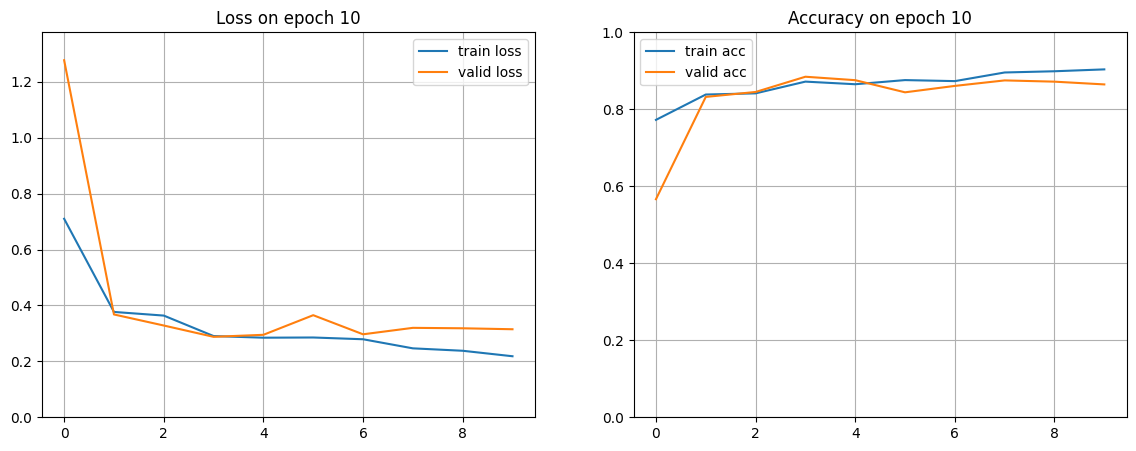

In [41]:
history = fit_model(model, 10, optimizer=optimizer)

In [42]:
history

{'train_accs': [np.float64(0.772474513714572),
  np.float64(0.8383051444248981),
  np.float64(0.8413461540118757),
  np.float64(0.871843141963683),
  np.float64(0.8650370721357414),
  np.float64(0.8758109362728624),
  np.float64(0.8731464319918529),
  np.float64(0.8955919835940901),
  np.float64(0.8987488416304071),
  np.float64(0.9036144578313253)],
 'train_losses': [np.float64(0.7101762313620154),
  np.float64(0.3768923819424158),
  np.float64(0.3638468014906688),
  np.float64(0.2905710021774453),
  np.float64(0.2847116421683725),
  np.float64(0.2854547971882016),
  np.float64(0.2791464620505471),
  np.float64(0.2466287191014692),
  np.float64(0.23796900289963527),
  np.float64(0.2183534453611776)],
 'valid_accs': [np.float64(0.5663690476545266),
  np.float64(0.8321428582781837),
  np.float64(0.844940477893466),
  np.float64(0.8845238089561462),
  np.float64(0.8755952375275748),
  np.float64(0.8440476201829457),
  np.float64(0.8607142851466224),
  np.float64(0.875),
  np.float64(0.87

In [47]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
        # ВАЖНО: сохраняем mapping классов
    'class_to_idx': safe_train_dataset.class_to_idx,
    'idx_to_class': safe_train_dataset.idx_to_class,
    'classes': list(safe_train_dataset.class_to_idx.keys()),  # Порядок классов
    'num_classes': len(safe_train_dataset.class_to_idx),
    'train_loss': history.get('train_losses'),
    'valid_loss': history.get('valid_losses'),
    'train_acc': history.get('train_accs'),
    'valid_acc': history.get('valid_accs'),
    'epochs_trained': len(history.get('train_losses'))
}



In [48]:
checkpoint

{'model_state_dict': OrderedDict([('features.0.0.weight',
               tensor([[[[ 8.8642e-01,  1.1542e+00,  9.9605e-01],
                         [ 9.6032e-01,  1.2053e+00,  9.4469e-01],
                         [ 5.5031e-02,  1.2406e-01, -1.9580e-02]],
               
                        [[-7.8663e-01, -9.8110e-01, -8.8535e-01],
                         [-8.0471e-01, -1.0118e+00, -8.1929e-01],
                         [-6.3146e-02, -1.4048e-01, -7.3514e-02]],
               
                        [[-6.5255e-02, -8.0724e-02, -9.9491e-02],
                         [-6.8162e-02, -9.4222e-02, -9.9032e-02],
                         [-3.6810e-02, -3.9777e-02, -3.4652e-02]]],
               
               
                       [[[-3.5179e-02, -1.5307e-02, -6.2368e-03],
                         [ 3.4643e-01,  7.0603e-01,  3.8925e-01],
                         [-4.2832e-01, -7.5138e-01, -4.3747e-01]],
               
                        [[ 1.4331e-02,  2.5757e-02,  1.2217e-02],

In [49]:
from google.colab import drive

# Подключаем Google Disk
drive.mount('/content/drive')

# Сохраняем checkpoint на Google Disk
def save_checkpoint_to_drive(checkpoint, filename='skin_cancer_model.pth'):
    """
    Сохраняет checkpoint на Google Disk
    """
    # Создаем папку для моделей если ее нет
    models_dir = '/content/drive/MyDrive/colab_models'
    os.makedirs(models_dir, exist_ok=True)

    # Полный путь для сохранения
    save_path = os.path.join(models_dir, filename)

    # Сохраняем checkpoint
    torch.save(checkpoint, save_path)

    # Проверяем что файл создан
    if os.path.exists(save_path):
        file_size = os.path.getsize(save_path) / 1024 / 1024  # Размер в MB
        print(f"✅ Checkpoint сохранен на Google Disk:")
        print(f"   📍 Путь: {save_path}")
        print(f"   📦 Размер: {file_size:.2f} MB")
        print(f"   🎯 Классы: {checkpoint['classes']}")
        print(f"   📊 Метрик: train_loss={len(checkpoint.get('train_loss', []))}, "
              f"valid_loss={len(checkpoint.get('valid_loss', []))}")
    else:
        print("❌ Ошибка при сохранении файла")

    return save_path

# Сохраняем на Google Disk
save_path = save_checkpoint_to_drive(checkpoint, 'skin_cancer_model_complete.pth')

Mounted at /content/drive
✅ Checkpoint сохранен на Google Disk:
   📍 Путь: /content/drive/MyDrive/colab_models/skin_cancer_model_complete.pth
   📦 Размер: 29.36 MB
   🎯 Классы: ['benign', 'malignant']
   📊 Метрик: train_loss=10, valid_loss=10


In [57]:
def get_prediction(model, path= '/content/skin_cancer_data/data/test/malignant/184.jpg', device='cpu') -> str:

    transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])



    image = Image.open(path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    model.to(device)
    with torch.no_grad():
        res = model(image_tensor)
        _, predicted = torch.max(res, 1)
        predicted_label = predicted.item()

        predicted_class = checkpoint['idx_to_class'].get(predicted_label)

    return predicted_class


In [58]:
print(get_prediction(model=model))

malignant
